   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 56.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.7/259.7 kB 13.9 MB/s eta 0:00:00
✅ Accuracy: 0.96
✅ F1 Score: 0.96


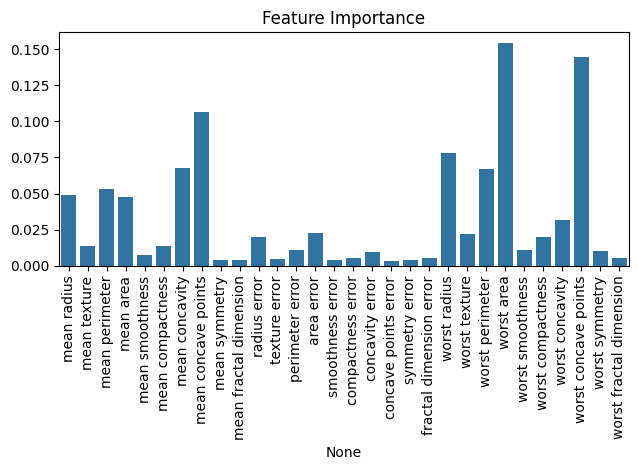

In [1]:
# Install required libraries
!pip install scikit-learn --upgrade --quiet
!pip install aif360 --quiet  # Optional: for fairness analysis

# Import libraries
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load Breast Cancer dataset
data = load_breast_cancer()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target  # 0 = malignant, 1 = benign

# Simulate issue priority based on diagnosis
df['priority'] = df['target'].map({0: 'high', 1: 'low'})

# Features and target
X = df.drop(['target', 'priority'], axis=1)
y = df['priority']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print("✅ Accuracy:", round(accuracy, 2))
print("✅ F1 Score:", round(f1, 2))

# Visualize feature importance
importances = model.feature_importances_
sns.barplot(x=X.columns, y=importances)
plt.xticks(rotation=90)
plt.title("Feature Importance")
plt.tight_layout()
plt.show()

In [3]:
# Install AI Fairness 360
!pip install aif360 --quiet
!pip install scikit-learn --upgrade --quiet

# Import libraries
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.algorithms.preprocessing import Reweighing

# Load Breast Cancer dataset
data = load_breast_cancer()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target  # 0 = malignant, 1 = benign

# Simulate issue priority based on diagnosis
df['priority'] = df['target'].map({0: 'high', 1: 'low'})

# Simulate a protected attribute (e.g., gender)
# 0 = unprivileged group, 1 = privileged group
np.random.seed(42)
df['gender_sim'] = np.random.choice([0, 1], size=len(df))

# Prepare binary label for fairness analysis
df['priority_binary'] = df['priority'].map({'low': 0, 'high': 1})

# Create BinaryLabelDataset
dataset = BinaryLabelDataset(
    df=df[['gender_sim', 'priority_binary']],
    label_names=['priority_binary'],
    protected_attribute_names=['gender_sim']
)

# Bias detection
metric = BinaryLabelDatasetMetric(
    dataset,
    privileged_groups=[{'gender_sim': 1}],
    unprivileged_groups=[{'gender_sim': 0}]
)

print(" Mean difference:", round(metric.mean_difference(), 4))
print(" Disparate impact:", round(metric.disparate_impact(), 4))

# Bias mitigation using Reweighing
rw = Reweighing(
    unprivileged_groups=[{'gender_sim': 0}],
    privileged_groups=[{'gender_sim': 1}]
)
dataset_transformed = rw.fit_transform(dataset)

# Check fairness after mitigation
metric_transformed = BinaryLabelDatasetMetric(
    dataset_transformed,
    privileged_groups=[{'gender_sim': 1}],
    unprivileged_groups=[{'gender_sim': 0}]
)

print("\n✅ After Reweighing:")
print(" Mean difference:", round(metric_transformed.mean_difference(), 4))
print(" Disparate impact:", round(metric_transformed.disparate_impact(), 4))

 Mean difference: 0.0319
 Disparate impact: 1.0895

✅ After Reweighing:
 Mean difference: 0.0
 Disparate impact: 1.0
